# [프로젝트] 모든 장르 간 편향성 측정
## STEP1. 형태소 분석기를 이용해 품사가 명사인 경우 해당 단어 추출
## STEP2. 추출된 결과로 embedding model 만들기
## STEP3. target, attribute 단어 셋 만들기
## STEP4. WEAT score 계산과 시각화
영화 시놉시스 코퍼스 - 영화 구분, 영화 장르 간 내재된 편향성 측정

모든 장르에 대해 영화 구분과의 편향성 정도 측정해보기

### STEP1. 형태소 분석기를 이용해 품사가 명사인 경우 해당 단어 추출

In [1]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

#### synopsis.txt 파일을 읽어 품사가 명사인 경우만 `tokenized` 변수명 저장
- konlpy 패키지 사용

In [2]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [3]:
print(len(tokenized))

71156


### STEP2. 추출된 결과로 embedding model 만들기

In [4]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.891642153263092),
 ('다큐멘터리', 0.855538547039032),
 ('드라마', 0.8122952580451965),
 ('소재', 0.8039849400520325),
 ('영화로', 0.7946990728378296),
 ('형식', 0.781105637550354),
 ('주제', 0.7794764637947083),
 ('영상', 0.7749284505844116),
 ('코미디', 0.7710517644882202),
 ('감동', 0.7694010138511658)]

In [5]:
# Word2Vec 훈련 확인
model.wv.most_similar(positive=['사랑'])

[('나비문신', 0.6939808130264282),
 ('진심', 0.6903746724128723),
 ('이별', 0.6893526911735535),
 ('토마슈', 0.6885605454444885),
 ('애정', 0.6875697374343872),
 ('연애', 0.6873390674591064),
 ('첫사랑', 0.6855354309082031),
 ('행복', 0.6824049949645996),
 ('아르튬', 0.6811994314193726),
 ('만남', 0.6800415515899658)]

In [6]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.9055874943733215),
 ('영화감독', 0.8905506134033203),
 ('대본', 0.8790368437767029),
 ('장영', 0.8751662373542786),
 ('영감', 0.8737584948539734),
 ('캐스팅', 0.8700755834579468),
 ('팬', 0.8676602840423584),
 ('배우', 0.8638417720794678),
 ('예술가', 0.8624330759048462),
 ('뤽', 0.8562567234039307)]

### STEP3. target, attribute 단어 셋 만들기
---
(문제)TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
- 중복되는 단어 발생 문제. 개념축을 표현하는 단어가 제대로 선정되지 않음
- 새로운 대표 단어 셋 구축. 중복된 단어 잘 제거하기

#### 'synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 읽고, 위에서 했던 것과 마찬가지로 명사에 대해서만 추출하여 art, gen 변수에 할당

In [7]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [8]:
# 2개의 파일을 처리(10분))
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


#### TfidVectorizer()을 통한 TF-IDF 방식 사용
##### WEAT 계산
- 총 4개의 단어 셋 X, Y, A, B가 필요
- 예술 영화 단어 art_txt -> art 단어 고르기.
- 예술 영화를 잘 대표하는 단어?? -> 예술영화-ok, 일반영화-no

In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [10]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

(문제) 
두 개념 대표 단어 TF-IDF 높은 순으로 추출, 중복된 단어가 많음

단어가 서로 중복되지 않게 단어 셋 추출.

### 중복된 단어를 잘 제거하기 위한 불용어 처리와 중복 제거
---
#### 1.	불용어 처리: stopwords 리스트를 정의하여, 불용어에 해당하는 단어들은 target_art 및 target_gen 리스트에 포함되지 않도록 필터링합니다.
#### 2.	중복 단어 제거: 이미 선택된 단어는 다시 리스트에 추가되지 않도록 target_art, target_gen에서 중복 단어를 필터링합니다.
#### 3.	Word2Vec 모델 사용: 단어가 Word2Vec 모델의 vocabulary에 존재하는 경우에만 선택하도록 조건을 추가하여 단어의 의미론적 정보를 유지합니다.
#### 4.	고유 단어 추출: extract_unique_words() 함수는 두 그룹에서 각각 고유한 단어를 추출합니다. w1은 art 관련 단어, w2는 일반 영화를 나타내는 단어들이며, 다른 그룹에서 중복되지 않는 단어만 선택됩니다.

**미리 실습해 봤던 결과를보면, `자신`, `위해` 가 많이 나온 것을 알 수 있다.**
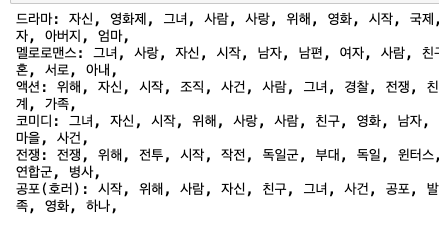

이건 그냥 봐도 의미없는 단어거나 상관없다는 판단 하에 다시 불용어처리로 넣어서 다시 출력해봤다.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

# 불용어 리스트
stopwords = ['영화', '배우', '감독', '작품', '연기', '관객', '장면', '자신', '위해']

# TF-IDF 벡터화된 데이터에서 고유 단어 추출을 위한 함수
def extract_unique_words(w1, w2, vectorizer, model, n=15):
    w1_, w2_ = [], []
    
    # TF-IDF로 추출된 feature names를 가져옴
    feature_names = vectorizer.get_feature_names_out()
    
    # w1 (art)와 w2 (gen)에서의 단어 리스트 생성
    for i in range(100):
        w1_.append(feature_names[w1[i][0]])
        w2_.append(feature_names[w2[i][0]])
    
    # 중복된 단어와 불용어를 제거하고 고유 단어 추출
    target_art, target_gen = [], []
    
    for i in range(100):
        # w1에만 있고 w2에는 없는 단어를 선택하고 불용어와 중복 단어 필터링
        if (w1_[i] not in w2_) and (w1_[i] not in stopwords) and (w1_[i] in model.wv) and (w1_[i] not in target_art):
            target_art.append(w1_[i])
        if len(target_art) == n: 
            break 

    for i in range(100):
        # w2에만 있고 w1에는 없는 단어를 선택하고 불용어와 중복 단어 필터링
        if (w2_[i] not in w1_) and (w2_[i] not in stopwords) and (w2_[i] in model.wv) and (w2_[i] not in target_gen):
            target_gen.append(w2_[i])
        if len(target_gen) == n: 
            break 

    return target_art, target_gen

# TF-IDF 결과를 가정한 데이터 (TF-IDF 계산은 생략된 상태)
# m1: art를 표현한 sparse matrix, m2: gen을 표현한 sparse matrix
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix

# w1: art 단어의 인덱스 및 TF-IDF 점수 리스트, w2: gen 단어의 인덱스 및 TF-IDF 점수 리스트
w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

# TF-IDF 점수가 높은 순서대로 정렬
w1.sort(key=lambda x: x[1], reverse=True)   # art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬
w2.sort(key=lambda x: x[1], reverse=True)   # gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬

# 불용어 처리 및 중복 단어 제거 후 대표 단어 추출
target_art, target_gen = extract_unique_words(w1, w2, vectorizer, model)

# 결과 출력
print("예술영화를 대표하는 단어들:", target_art)
print("일반영화를 대표하는 단어들:", target_gen)

예술영화를 대표하는 단어들: ['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
일반영화를 대표하는 단어들: ['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [13]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [14]:
# 장르 파일 토큰화
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


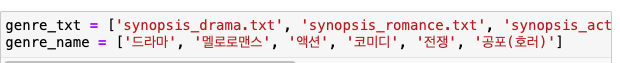
'드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)' 장르는

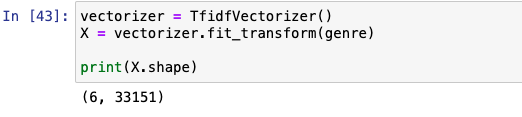
이정도 개수에서 

모든 장르는
21, 42191개로 늘어난 걸 알 수 있다.

In [17]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

### STEP4. WEAT score 계산과 시각화
traget_X는 art, target_Y는 gen, attribute_A는 '드라마', attribute_B는 '액션' 과 같이 정하기

target_X 는 art, target_Y 는 gen으로 고정 -> attribute_A, attribute_B를 바꿔가면서 구해보기

구현결과(21x21 매트릭스 형태 표현=matrix)

In [18]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 단어 임베딩 벡터 간의 유사도를 계산하는 함수
def cosine_similarity_score(vec1, vec2):
    return cosine_similarity([vec1], [vec2])[0][0]

# WEAT에서 s(w, A, B): w가 A와 B에 얼마나 더 가까운지 계산하는 함수
def s(w, A, B):
    # w와 A 그룹의 유사도 - w와 B 그룹의 유사도 계산
    return np.mean([cosine_similarity_score(w, a) for a in A]) - np.mean([cosine_similarity_score(w, b) for b in B])

# WEAT 점수를 계산하는 함수
def weat_score(X, Y, A, B):
    # 각 그룹 X와 Y의 WEAT s 값을 계산
    s_X = np.array([s(x, A, B) for x in X])
    s_Y = np.array([s(y, A, B) for y in Y])

    # X와 Y의 평균 차이 계산
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    # 표준 편차 계산
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))

    # WEAT 점수 계산 (표준 편차가 0인 경우 0을 반환)
    return (mean_X - mean_Y) / std_dev if std_dev != 0 else 0

# 예시 단어 벡터 집합 X, Y, A, B (2차원 배열로 생성)
X = np.random.rand(10, 300)  # 10개의 300차원 벡터로 구성된 X 집합 (임의의 데이터)
Y = np.random.rand(10, 300)  # 10개의 300차원 벡터로 구성된 Y 집합 (임의의 데이터)
A = np.random.rand(5, 300)   # 5개의 300차원 벡터로 구성된 A 속성 (임의의 데이터)
B = np.random.rand(5, 300)   # 5개의 300차원 벡터로 구성된 B 속성 (임의의 데이터)

# WEAT 점수 계산
weat_result = weat_score(X, Y, A, B)
print(f"WEAT Score: {round(weat_result, 3)}")

WEAT Score: 0.34


In [19]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [20]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [21]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.7796058
SF 공연 -0.23688132
SF 공포(호러) -0.72151744
SF 기타 0.14976354
SF 다큐멘터리 0.44863635
SF 드라마 -0.52346146
SF 멜로로맨스 -0.76552093
SF 뮤지컬 0.20566356
SF 미스터리 -0.7126519
SF 범죄 -0.26292536
SF 사극 -0.61824995
SF 서부극(웨스턴) -0.3029632
SF 성인물(에로) -0.52899915
SF 스릴러 -0.5691554
SF 애니메이션 0.13279295
SF 액션 -0.55795765
SF 어드벤처 -0.779322
SF 전쟁 0.35400355
SF 코미디 -0.61425966
SF 판타지 -0.38913736
가족 공연 0.67395914
가족 공포(호러) 0.1557474
가족 기타 0.85925615
가족 다큐멘터리 0.9237778
가족 드라마 0.351736
가족 멜로로맨스 -0.38142076
가족 뮤지컬 0.82639474
가족 미스터리 -0.04689422
가족 범죄 0.46498653
가족 사극 0.5214633
가족 서부극(웨스턴) 0.7167461
가족 성인물(에로) -0.04909581
가족 스릴러 0.12425813
가족 애니메이션 0.9611863
가족 액션 0.40186745
가족 어드벤처 0.43084118
가족 전쟁 0.8686608
가족 코미디 0.31339782
가족 판타지 0.59350795
공연 공포(호러) -0.33453923
공연 기타 0.5944772
공연 다큐멘터리 0.71154773
공연 드라마 -0.3886836
공연 멜로로맨스 -0.7146174
공연 뮤지컬 0.7256132
공연 미스터리 -0.428529
공연 범죄 -0.01607355
공연 사극 -0.2392186
공연 서부극(웨스턴) -0.03431368
공연 성인물(에로) -0.4892074
공연 스릴러 -0.3126508
공연 애니메이션 0.56264895
공연 액션 -0.15781273

## 해석

- 값이 클수록 연관성이 강하고, 작을 수록 연관성이 낮다.

#### SF(공상 과학) 장르:
---
SF - `가족 (-0.7029941)`와 같은 값은 SF 장르가 가족 장르와 **부정적인 연관성** 을 가진다는 것을 의미

즉, SF 영화는 가족 영화와 내재된 연관성이 낮다고 봄

반대로, SF - `다큐멘터리 (0.48172992)` 같은 값은 SF와 다큐멘터리 장르 간의 연관성이 **비교적 높다는 것**을 의미

#### 가족 장르:
---
가족 - `애니메이션 (0.9828525)`는 매우 높은 양수 값. 이는 가족 장르와 애니메이션 장르가 **매우 강한 연관성**을 가지고 있다는 것을 의미 가족 영화는 애니메이션 영화와 매우 밀접하게 연관되어 있다는 것

반대로, 가족 - `멜로로맨스 (-0.35970694)`는 가족과 멜로로맨스 장르가 그다지 연관성이 없음

#### 공포(호러) 장르:
---
공포(호러) - `다큐멘터리 (0.73992795)`는 공포와 다큐멘터리 장르가 **강한 연관성**.

공포(호러) - `애니메이션 (0.63192683)`는 공포 영화와 애니메이션 영화 간에도 **비교적 높은 연관성**이 있음

공포(호러) - `미스터리 (-0.5462546)`는 두 장르 간의 **연관성이 낮음**을 보여줍니다. 공포와 미스터리 장르는 예상보다 연관성이 적은 것으로 나타나며, 이는 장르적 특성 차이를 반영할 수 있습니다.


#### 공연 장르:
---
공연 - `기타 (0.58169943)`와 같은 양수 값은 공연 장르가 기타 장르와 **높은 연관성**을 가지고 있음 (공연과 기타 장르는 공통된 주제나 분위기를 공유할 가능성)

반면, 공연 - `멜로로맨스 (-0.7106934)`와 같이 음수 값이 큰 경우는 공연 장르와 멜로로맨스 장르가 상반된 특성을 지닌다는 것을 의미. 공연 장르는 멜로로맨스와의 **연관성이 낮다.**

공연 - `다큐멘터리 (0.68249506)`는 공연과 다큐멘터리 장르 간의 **높은 연관성**을 나타냅니다. 이는 공연과 다큐멘터리 영화가 주제적으로 연결될 가능성이 높다는 것을 의미합니다.


#### 기타 장르:
---
기타 - `다큐멘터리 (0.58322096)`는 기타 장르와 다큐멘터리 장르가 **강한 연관성.**

기타 - `드라마 (-0.92244124)`와 같이 음수 값이 큰 경우는 기타 장르와 드라마 장르가 상반된 특성을 지닌다는 것을 의미합니다.

기타 - `코미디 (-0.7952593)`처럼 음수 값이 큰 경우는 기타 장르와 코미디 장르 간의 **연관성이 낮음**을 나타냅니다.


#### 다큐멘터리 장르:
---

다큐멘터리 - `드라마 (-0.94468135)`는 다큐멘터리와 드라마가 연관성이 **매우 낮음**을 나타냅니다. 이는 다큐멘터리의 사실적인 특성과 드라마의 감정적인 서사가 상반된다는 점을 반영.
	
다큐멘터리 - `멜로로맨스 (-0.898256)` 역시 다큐멘터리와 멜로로맨스가 **연관성이 낮다**. 멜로로맨스 장르와 다큐멘터리의 주제나 서사가 다르다는 것을 나타냄


#### 드라마 장르:
---

드라마 - `멜로로맨스 (-0.77241325)`는 드라마와 멜로로맨스가 상반된 주제를 지닌다고 해석. 이 점수는 두 장르가 큰 차이를 가진다는 것.

드라마 - `뮤지컬 (0.75381386)`은 드라마와 뮤지컬 장르가 **서로 강한 연관성**을 가지고 있음. 드라마와 뮤지컬은 감정적 서사와 예술적 표현에서 유사한 특성을 가질 수 있다.

드라마 - `애니메이션 (0.8812431)`는 드라마와 애니메이션 간의 **매우 높은 연관성**을 나타냅니다. 이는 두 장르가 감정적 표현이나 스토리텔링에서 유사한 성격을 가지고 있을 수 있음


#### 멜로로맨스 장르:
---

멜로로맨스 - `성인물(에로) (0.8373372)`는 이 두 장르가 매우 **높은 연관성**을 가지는 것으로 보이며, 이는 두 장르 모두 감정적이고 성적인 주제를 다루기 때문일 수 있습니다.

멜로로맨스 - `애니메이션 (0.85960263)`은 멜로로맨스와 애니메이션 장르 간의 **높은 연관성**을 보여줍니다. 이는 애니메이션에서도 로맨스적인 요소가 자주 등장할 수 있기 때문일 수 있습니다.

멜로로맨스 - `미스터리 (0.35753167)`는 두 장르가 **다소 연관성**이 있음을 나타냅니다
미스터리 장르에서도 로맨스적인 서브 플롯이 포함될 수 있기 때문입니다.


#### 뮤지컬 장르:
---

뮤지컬 - `애니메이션 (-0.19554007)`는 약한 음수 값을 나타냄, 두 장르 간의 **상관성이 크지 않음**. 

뮤지컬 - `코미디 (-0.67375344)`와 같은 경우, 두 장르 간의 상관성이 **매우 낮다**. 이는 뮤지컬이 예술적 표현과 노래를 중심으로 하는 반면, 코미디는 유머와 가벼운 서사를 강조하는 장르적 차이 때문.

뮤지컬 - `미스터리 (-0.61853033)`도 유사하게 연관성이 낮음. 미스터리 장르는 서스펜스와 복잡한 스토리 구조를 가지는 반면, 뮤지컬은 감정 표현과 음악적 요소에 집중되어 있어, 이 두 장르는 잘 섞이지 않을 수 있다.


#### 미스터리 장르:
---

미스터리 - `범죄 (1.0045581)`는 매우 강한 양수 값으로, 두 장르 간의 **밀접한 연관성**. 이는 범죄 스토리가 종종 미스터리 장르 내에서 중요한 요소로 작용하기 때문.

미스터리 - `스릴러 (0.71143395)` 역시 **강한 연관성**. 이 두 장르는 공통적으로 긴장감과 예측할 수 없는 요소가 중심이 되는 서사를 가지므로, 높은 연관성을 나타냄.

미스터리 - `액션 (0.7250364)`는 비교적 **강한 연관성**을 나타냅니다. 미스터리 요소가 액션 영화의 서브 플롯으로 자주 포함


#### 범죄 장르:
---

범죄 - `스릴러 (-0.9539968)`는 음수 값으로 두 장르 간의 **연관성이 낮음**. 이는 스릴러가 긴장감을 중심으로 한 장르인 반면, 범죄는 종종 법률적이거나 사회적인 요소를 다루기 때문에, 두 장르가 완전히 상반된 방식으로 표현될 수 있다는 점에서 기인

범죄 - `애니메이션 (0.26969752)`는 **약한 양수 값**을 나타내며, 연관성이 다소 있지만 강하지는 않다는 것을 의미. 애니메이션 내에서도 범죄 요소가 포함될 수 있지만, 이는 드문 편.


#### 사극 장르:
---
사극 - `전쟁 (0.8258398)`는 매우 **높은 연관성**을 보여줍니다. 이는 사극이 역사적 전쟁을 다룰 때가 많기 때문에, 두 장르 간의 연관성이 클 수밖에 없다.

사극 - `애니메이션 (0.7122208)`는 예상외로 **높은 연관성**을 보입니다. 이는 사극적인 요소가 애니메이션에서도 종종 중요한 배경 설정으로 등장할 수 있음을 시사

사극 - `코미디 (-0.1774469)`는 두 장르 간의 **낮은 연관성**. 사극은 보통 진지하고 역사적인 내용을 다루는 반면, 코미디는 가벼운 서사를 주로 다루기 때문에 두 장르 간의 상관성이 낮은 것.


#### 서부극(웨스턴) 장르의 연관성:
---
서부극 - `전쟁 (0.7832851)`는 두 장르 간의 **높은 연관성**. 서부극과 전쟁은 둘 다 폭력적인 서사와 전투 장면을 포함하는 경우가 많으며, 이러한 점에서 연관성이 큼.

서부극 - `애니메이션 (0.4977311)`도 **비교적 강한 연관성**을 보이는데, 이는 서부극적인 요소가 애니메이션 장르에도 자주 사용될 수 있음을 시사.


#### 성인물(에로) 장르:
---
성인물(에로) - `애니메이션 (0.69420666)`는 **비교적 높은 양수 값**을 나타내며, 두 장르 간의 연관성이 강함. 이는 성인물이 애니메이션에서도 표현될 수 있는 경우가 있으며, 성인물과 애니메이션의 일부 하위 장르가 공통적으로 나타날 수 있음을 의미

성인물(에로) - `전쟁 (0.5534855)` **역시 강한 연관성**. 성인물 내에서 전쟁과 관련된 서사적 요소가 포함될 수 있음을 시사

성인물(에로) - `액션 (0.30454057)`과 `코미디 (0.33478957)`는 **중간 정도의 양수 값**을 보여주며, 두 장르가 결합된 작품이 존재할 수 있음을 암시.


#### 스릴러 장르:

스릴러 - `애니메이션 (0.5277573)`와 스릴러 - `전쟁 (0.5846573)`는 **높은 연관성**. 스릴러와 애니메이션이 결합된 서사나, 스릴러와 전쟁 요소가 함께 있는 작품이 상당수 존재할 수 있음.

스릴러 - `코미디 (0.1234494)`는 약한 연관성을 보이는데, 이는 스릴러가 긴장감과 서스펜스를 주로 다루는 반면, 코미디는 가벼운 분위기를 다루는 장르적 차이 때문.

스릴러 - `판타지 (0.29556844)`는 중간 정도의 연관성을 나타내며, 판타지적인 요소가 스릴러 작품에서 나타날 수 있음을 의미.


#### 애니메이션 장르:

애니메이션 - `액션 (-0.4239758)`와 애니메이션 - `어드벤처 (-0.93217003)`는 **음수 값**을 보이며, 이 두 장르 간의 **상관성이 낮음**. 애니메이션이 보다 서사적이거나 환상적인 요소를 담고 있기 때문에, 액션이나 어드벤처와는 스타일적으로 다를 수 있다.

애니메이션 - `판타지 (-0.7198925)` 역시 음수 값을 보이며, 이 두 장르 간의 **연관성이 낮음**을 나타냄. 애니메이션이 판타지적 요소를 다루긴 하지만, 판타지가 전는 약한 음수 값을 보이며, 두 장르 간의 연관성이 낮음. 하지만 이것도 판타지 애니메이션 소재도 많기에 더 조사

이는 액션 영화가 서사적 요소보다는 폭력적이거나 전투적인 요소에 더 중점을 두는 반면, 어드벤처는 더 탐험적이고 서사 중심의 이야기를 다루기 때문.

액션 - `전쟁 (0.5774789)`는 **높은 양수 값**을 보이며, 두 장르 간의 **상관성이 높음**을 나타냄. 액션 영화가 전쟁과 폭력적인 요소를 자주 다루기 때문에 두 장르가 자주 결합.

액션 - `판타지 (0.095638394)`는 **매우 낮은 양수 값**을 보이며, 판타지 요소와 액션 요소가 함께 나타나는 경우가 많지는 않다는 것을 보여줌


#### 전쟁 장르:

전쟁 - `어드벤처 (0.6939699)`는 **높은 양수 값**을 보이며, 전쟁 영화 내에서 모험적인 서사가 포함

전쟁 - `코미디 (-0.5842947)`와 전쟁 - `판타지 (-0.4270368)`는 음수 값을 보이며, 이 두 장르 간의 **연관성이 낮음**. 전쟁은 보통 무거운 서사를 중심으로 하며, 가벼운 서사를 다루는 코미디나 환상적인 요소를 다루는 판타지와는 결합되는 경우가 적다.

#### 코미디 장르:

코미디 - `판타지 (0.53189)`는 양수 값을 보이며, 두 장르 간의 상관성이 **비교적 높음**을 보여줌. 코미디 내에서 판타지적 요소가 포함된 작품들이 많을 수 있다.

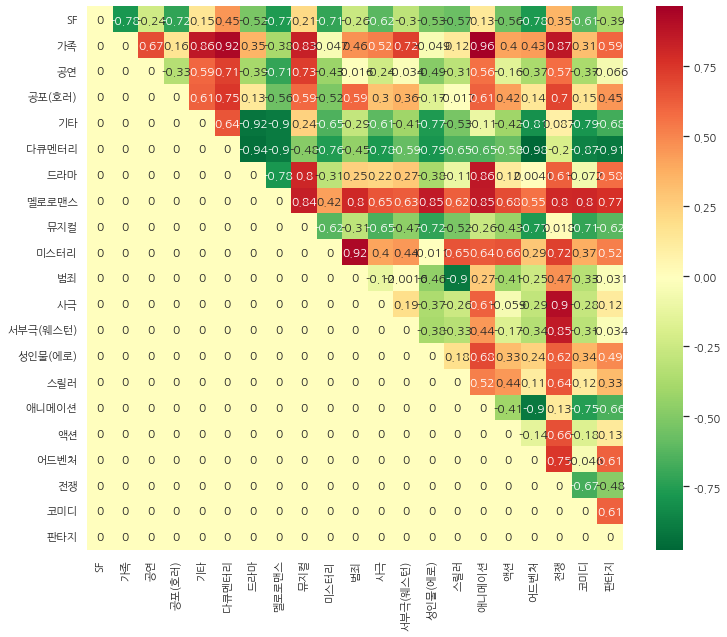

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 지원
plt.rcParams['axes.unicode_minus'] = False

# 히트맵 크기 조정
plt.figure(figsize=(12, 10))  # 원하는 크기로 figsize 설정 (예: 12x10)

# 히트맵 생성
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, cmap='RdYlGn_r')

# 그래프 표시
plt.show()

### 아쉬운 점
장르에 연관되는 단어 중 의미없는 단어를 제외하고 싶었는데, 실험할 때 그것이 잘 안됐었다.
어느 부분에서부터 해결해야 하는지 생각을 해보고 적용해보고 넘어가야겠다는 생각이 들었다.

## 회고


이렇게 영화 시놉시스 데이터셋에서 영화 구분, 장르에 따른 편향성을 측정해보고 그것을 WEAT 스코어를 통해 알아보는 시간이 좋았다.

특히, 인공지능이 잘못된 학습을 충분히 할 수 있겠구나 라는 생각이 들며, 이를 뒷받침하는 부분을 오늘 학습한 경험으로
충분히 나눠볼 수 있고, 어느정도 해결해 나가는 방안을 고안할 수 있겠다는 생각이 들었다.

서비스를 개발하고자 하는 나에게는 이와 비슷한 과제 또는 문제들을 해결해나가야 하는 능력을 키워야겠다는 다짐이 들었다.